# Basics of Deep Learning

In [1]:
student_id = 400101656 #@param {type:"integer"}
student_name = "Pantea Amoie" #@param {type:"string"}

When completing the notebook, please adhere to the following rules:
- Do not write or modify any code outside of code blocks
- Do not add or delete any cells from the notebook. You may add new cells to perform scatch work, but delete them before submitting.
- Run all cells before submitting. You will only get credit for code that has been run.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook).

In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# TODO: Enter the foldername in your Drive where you have saved the
# assignment files, e.g. 'DL/assignments/assignment1/'
FOLDERNAME = "DL/assignments/assignment1/"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

The dataset for this exercise is CIFAR-10. Let's first download it then we'll explore it.

In [4]:
# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

/content/drive/My Drive/DL/assignments/assignment1/datasets
/content/drive/My Drive/DL/assignments/assignment1


In [5]:
import os
import pytz
from datetime import datetime

# The file path
GOOGLE_DRIVE_PATH = '/content/drive/My Drive/{}'.format(FOLDERNAME)
pytorch_path = os.path.join(GOOGLE_DRIVE_PATH, 'k_nearest_neighbor.py')

# Get the last modified time in UTC
last_modified_time = os.path.getmtime(pytorch_path)
utc_time = datetime.utcfromtimestamp(last_modified_time)

# Define Iran's time zone
iran_tz = pytz.timezone('Asia/Tehran')

# Convert UTC time to Iran time
iran_time = pytz.utc.localize(utc_time).astimezone(iran_tz)

# Print the result in Iran's local time
print(f"k_nearest_neighbor.py last edited on: {iran_time.strftime('%Y-%m-%d %H:%M:%S')}")

k_nearest_neighbor.py last edited on: 2024-10-25 17:08:20


# k-Nearest Neighbor (kNN)

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

You will implement these steps in this notebook and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

The following code is to setup the enviroment

In [6]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is to make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# This is here so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [7]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [8]:
################################################################################
# TODO:                                                                        #
# As a sanity check, print out the size of the training and test data and      #
# also the size of their labels                                                #
################################################################################

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

print(f"Size of training data : {X_train.shape}")
print(f"Size of training labels : {y_train.shape}")
print(f"Size of test data : {X_test.shape}")
print(f"Size of test labels : {y_test.shape}")

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

Size of training data : (50000, 32, 32, 3)
Size of training labels : (50000,)
Size of test data : (10000, 32, 32, 3)
Size of test labels : (10000,)


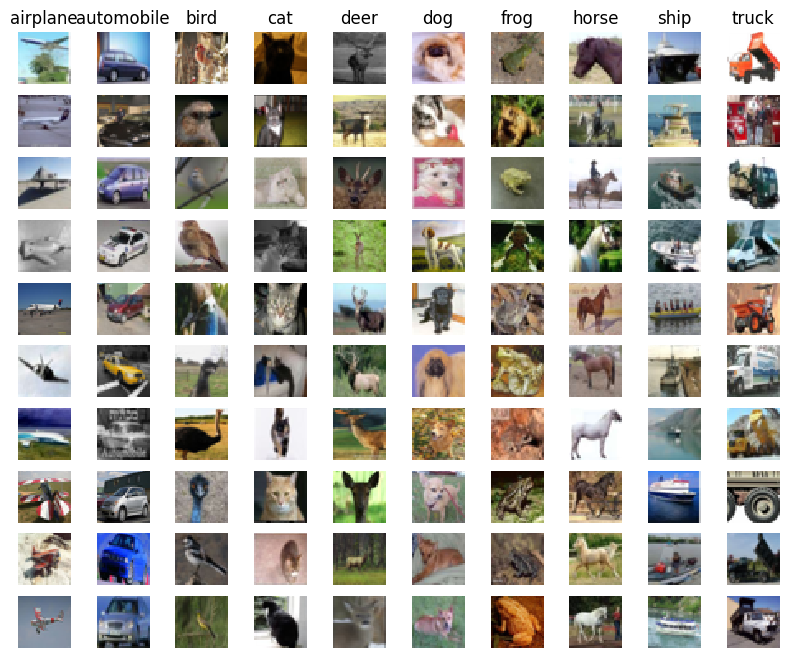

In [9]:
classes = []
num_classes = None
samples_per_class = 10

################################################################################
# TODO:                                                                        #
# Explore the dataset and find its classes. Then visualize some examples.      #
# To do so show a few examples of training images from each class              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# **I assumed that we don't know the class names of cifar10 and we should find them by code, so I wrote this code
# to find the names of the 10 class:
import pickle
def get_CIFAR10_class_names(cifar10_dir):
    meta_file = os.path.join(cifar10_dir, 'batches.meta') # path to the batches.meta file that contains class names
    with open(meta_file, 'rb') as f:
        meta_data = pickle.load(f, encoding='bytes')
    class_names = meta_data[b'label_names'] # class names are as a list of byte strings so we need to convert them to regular strings
    class_names = [name.decode('utf-8') for name in class_names]
    return class_names

# **We could also have the class names ourselves, like so:
# classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

unique_classes = np.unique(y_train)
num_classes = len(unique_classes)
classes = get_CIFAR10_class_names(cifar10_dir)

for idx, name in enumerate(classes):
    # Choosing 10 random indices from each class
    idxs = np.where(y_train == idx)[0]
    chosen_idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, j in enumerate(chosen_idxs):
        plt.subplot(samples_per_class, num_classes, i * num_classes + idx + 1)
        plt.imshow(X_train[j].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(name)
plt.show()


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

In [10]:
################################################################################
# TODO:                                                                        #
# Subsample the data for more efficient code execution in this exercise.       #
# You should reduce the number of training and test examples used.             #
# Set num_training to 5000 and num_test to 500.                                #
# Reshape the image data into rows to prepare for processing.                  #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

num_training = 5000
num_test = 500

X_train_reduced = X_train[:num_training]
y_train_reduced = y_train[:num_training]
X_test_reduced = X_test[:num_test]
y_test_reduced = y_test[:num_test]

# (5000, 32, 32, 3) -> (5000, 32 * 32 * 3)
X_train_reshaped = np.reshape(X_train_reduced, (X_train_reduced.shape[0], -1))
# (500, 32, 32, 3) -> (500, 32 * 32 * 3)
X_test_reshaped = np.reshape(X_test_reduced, (X_test_reduced.shape[0], -1))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

In [11]:
from k_nearest_neighbor import KNearestNeighbor

################################################################################
# TODO:                                                                        #
# Create a kNN classifier instance and call its training method.                #
# Remember that training a kNN classifier is a noop:                           #
# the classifier simply remembers the data and does no further processing.     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

classifier = KNearestNeighbor()
classifier.train(X_train_reshaped, y_train_reduced)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

1. First we must compute the distances between all test examples and all train examples.
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [12]:
# Open k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# TODO: Test your implementation:
dists = classifier.compute_distances_two_loops(X_test_reshaped)
print(dists.shape)

(500, 5000)


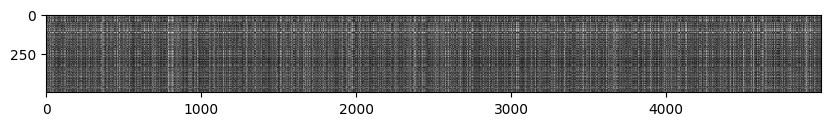

In [13]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1**

Notice the structured patterns in the distance matrix, where some rows or columns are visibly brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{pink}{\textit Your Answer:}$
- Bright rows represent test examples that have high distances with most of the training examples. This could happen when test examples have quite different features than the training set, which probably means our train set doesn't represent all the possible classes (and the test example comes from one of the classes the train set does not have examples from) meaning that the training set might not adequately represent all possible classes or cover the entire feature space, which leads to poor generalization. Another probability is that the test example is an outlier or has a distinctly different content than the train examples.
- Bright columns represent training examples that have high distances with most of the test data. This could happen if certain training examples are outliers or represent uncommon feature combinations. These training examples might not have matches with close features in the test data.


In [14]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# TODO: Compute and print the fraction of correctly predicted examples

num_correct = np.sum(y_test_pred == y_test_reduced)
accuracy = num_correct / num_test
print('%d / %d were correct => accuracy: %f' % (num_correct, num_test, accuracy))

137 / 500 were correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [15]:
# TODO: Do the same as before with k=5
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test_reduced)
accuracy = num_correct / num_test

print('%d / %d were correct => accuracy: %f' % (num_correct, num_test, accuracy))

139 / 500 were correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$,

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply. To clarify, both training and test examples are preprocessed in the same way.

1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data, which means rotating all the images by the same angle. Empty regions in the image caused by rotation are padded with a same pixel value and no interpolation is performed.

$\color{pink}{\textit Your Answer:}$
- 1 & 2 & 3


$\color{pink}{\textit Your Explanation:}$
- 1 : If we subtract the overall mean from all the pixel values, the L1 knn will have the same performance because we are shifting all pixel values similarly. To compute the L1 loss, we need to calculate the sum of the absolute difference between each training data and test data, and by subtracting the overall mean from both of them, the means would cancel out, and the new absolute difference would be the same as the old one.
- 2 : We can calculate the L1 loss between two images (k'th train and l'th test) as follows:\
$$ L_{1, kl} = \sum_{i=1}^{h}\sum_{j=1}^{w}{|p_{ij}^{(k)}-p_{ij}^{(l)}|} $$
Now if we subtracting the per pixel mean, we'll have:
$$ L_{1, kl} = \sum_{i=1}^{h}\sum_{j=1}^{w}{|(p_{ij}^{(k)}-\mu_{ij})-(p_{ij}^{(l)}-\mu_{ij})|} = \sum_{i=1}^{h}\sum_{j=1}^{w}{|p_{ij}^{(k)}-p_{ij}^{(l)}|} $$
So the KNN performance will not change.

- 3 : The point of calculating distances in KNN, is comparing these distances with eachother. So if the ordering of distances is preserved, the performance of KNN will not be affected. We prove the ordering is preserved in this method:\
$$ \text{if } L_{1, kl} = \sum_{i=1}^{h}\sum_{j=1}^{w}{|p_{ij}^{(k)}-p_{ij}^{(l)}|} < L_{1, kr} = \sum_{i=1}^{h}\sum_{j=1}^{w}{|p_{ij}^{(k)}-p_{ij}^{(r)}|} $$\
$$ \sum_{i=1}^{h}\sum_{j=1}^{w}{|\frac{(p_{ij}^{(k)}-\mu)}{\sigma }-\frac{(p_{ij}^{(l)}-\mu)}{\sigma }|} = \frac{1}{\sigma}\sum_{i=1}^{h}\sum_{j=1}^{w}{|p_{ij}^{(k)}-p_{ij}^{(l)}|} < \frac{1}{\sigma}\sum_{i=1}^{h}\sum_{j=1}^{w}{|p_{ij}^{(k)}-p_{ij}^{(r)}|} = \sum_{i=1}^{h}\sum_{j=1}^{w}{|\frac{(p_{ij}^{(k)}-\mu)}{\sigma }-\frac{(p_{ij}^{(r)}-\mu)}{\sigma }|} $$\
Therefore the ordering of distances is preserved:\
$$ \sum_{i=1}^{h}\sum_{j=1}^{w}{|\frac{(p_{ij}^{(k)}-\mu)}{\sigma }-\frac{(p_{ij}^{(l)}-\mu)}{\sigma }|} < \sum_{i=1}^{h}\sum_{j=1}^{w}{|\frac{(p_{ij}^{(k)}-\mu)}{\sigma }-\frac{(p_{ij}^{(r)}-\mu)}{\sigma }|} $$ \

- 4 : Dividing by the pixel-wise standard deviation, causes different scaling for different dimensions, and we cannot factorize it out like we did for part 3. Therefore the performance of KNN can change.

- 5 : L1 distance is variant to the rotation of the coordinate axes, unlike L2.
For instance imagine we have a line with lenth 1 in the direction of x axis. If we rotate it 45 degrees, it will still have L2 norm equal to 1, but it will have L1 norm equal to $\frac{1}{\sqrt{2}} . 2 = \sqrt{2} $. Rather than rotating the line, we could also equivalently rotated our x and y axis instead.


In [16]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test_reshaped)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm.

difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [17]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test_reshaped)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


Explain how you have implemented compute_distances_no_loops

$\color{pink}{\textit Your Answer:}$\
We use vectorized operations to calculate the L2 distances between each test point in X and each training point in `self.X_train` without any explicit loops using this formula:\
The L2 distance between two points is : \
$ || a - b ||^2 = ||a||^2 + ||b||^2 - 2a\cdot b $ \
Using this formula allows us to separate the calculation into parts that can be vectorized over all test and training points simultaneously.\
We calculate the squared L2 norm of each test point in X.
`test_squared = np.sum(X ** 2, axis=1).reshape(-1, 1)` computes the squared sum of each row in X and reshapes the result into a column vector (shape (num_test, 1)) to facilitate broadcasting in the next steps.\
Similarly, we calculate the squared norms of each training point in self.X_train:
`train_squared = np.sum(self.X_train ** 2, axis=1)` gives a 1D array of shape (num_train,) containing the squared sums for each row in `self.X_train`.\
The cross term, `cross_term = np.dot(X, self.X_train.T)`, computes the inner product between all pairs of test and training points.
X has a shape of (num_test, D), and self.X_train.T (the transpose of self.X_train) has a shape of (D, num_train). The dot product results in a matrix of shape (num_test, num_train), where each element
(i,j) is the inner product between the i-th test point and the j-th training point. Now, using the squared L2 distance formula, we compute: $dists = \sqrt{\text{test_squared} + \text{train_squared} - 2 \times \text{cross_term}}$ .
Since test_squared is (num_test, 1) and train_squared is (num_train,), broadcasting ensures each element in test_squared is paired with each element in train_squared. Finally, we take the square root of each element in the matrix `dists` to convert the squared distances into Euclidean distances.

In [19]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test_reshaped)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop,  X_test_reshaped)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops,  X_test_reshaped)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using,
# you might not see a speedup when you go from two loops to one loop,
# and might even see a slow-down.

Two loop version took 39.576649 seconds
One loop version took 60.474195 seconds
No loop version took 0.595718 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [20]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

X_train_folds = np.array_split(X_train_reshaped, num_folds)
y_train_folds = np.array_split(y_train_reduced, num_folds)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for k in k_choices:

    k_to_accuracies[k] = []

    for i in range(num_folds):

        # Cross validation
        X_val_fold = X_train_folds[i]
        y_val_fold = y_train_folds[i]
        X_train_fold = np.concatenate([X_train_folds[j] for j in range(num_folds) if j != i])
        y_train_fold = np.concatenate([y_train_folds[j] for j in range(num_folds) if j != i])

        # Training the classifier
        classifier = KNearestNeighbor()
        classifier.train(X_train_fold, y_train_fold)

        # Predicting on the validation set
        y_val_pred = classifier.predict(X_val_fold, k=k)

        # Computing accuracy and adding to the list for the current k
        accuracy = np.mean(y_val_pred == y_val_fold)
        k_to_accuracies[k].append(accuracy)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

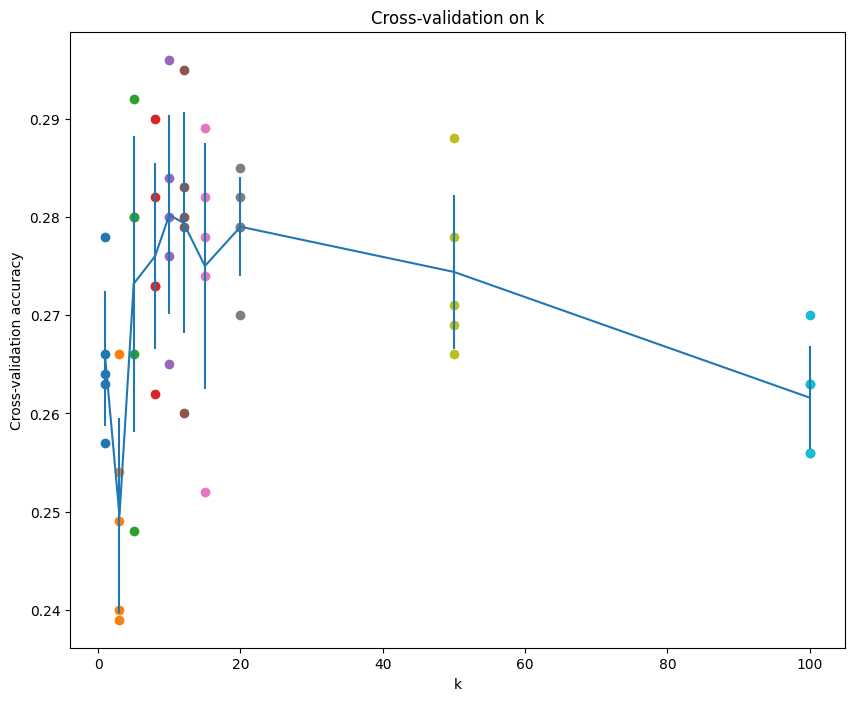

In [21]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [25]:
# TODO: Based on the cross-validation results above, choose the best value for k,
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

# Retraining the classifier
classifier = KNearestNeighbor()
classifier.train(X_train_reshaped, y_train_reduced)

# Testing the classifier on the test set
y_test_pred = classifier.predict(X_test_reshaped, k=best_k)

# Computing the accuracy on the test set
num_correct = np.sum(y_test_pred == y_test_reduced)
num_test = y_test_reduced.shape[0]
accuracy = float(num_correct) / num_test

print('%d / %d were correct => accuracy: %f' % (num_correct, num_test, accuracy))

141 / 500 were correct => accuracy: 0.282000


**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than or equal to that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{pink}{\textit Your Answer:}$ 2 & 4


$\color{pink}{\textit Your Explanation:}$\
**1.**  False: The decision boundary of k-NN is not linear. It can be very complex and depends on the distribution of the training points.\
**2.** True: In $k = 1$, the nearest point to each training example will be itself, with zero training error. For $k = 5$, the error might be more than 0 (it's possible for some points to be misclassified by their neighbors), so the statement holds.\
**3.** False: Assume we have $ x_{train} = (3, 4, 5, 6, 7)$ and $ y_{train} = (0, 0, 0, 0, 1) $. For the test point $ x_{test} = 8 $ we have $ y_{test} = 0 $.
For $k=1$ we'll get $ y_{pred} = 1 $ which means we will have an error of 100%. But for, $k=5$ we'll have $ y_{pred} = 0 $, which means we will have an error of 0%.\
**4.** True:  In k-NN, classifying a test example requires computing the distance from the test point to all training points, so the time complexity grows with the size of the training set.

